In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
main_speakers = ["Chandler", "Monica", "Ross", "Rachel", "Phoebe", "Joey"]
emotions = ["neutral", "joy", "surprise", "anger", "sadness", "disgust", "fear"]

viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(emotions)))
emotion_colors = dict(zip(emotions, viridis_colors))

emotion_colors["neutral"] = "#808080"
emotion_colors["anger"] = "#DC143C"

In [3]:

df = pd.read_csv("./data/train_sent_emo.csv")
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


## Transformação dos dados

In [4]:

def to_seconds(t):
    h, m, s_ms = t.split(":")
    s, ms = s_ms.split(",")
    return int(h)*3600 + int(m)*60 + int(s) + int(ms)/1000

df["start_s"] = df["StartTime"].apply(to_seconds)
df["end_s"] = df["EndTime"].apply(to_seconds)
df["duration_s"] = df["end_s"] - df["start_s"]

df[df["duration_s"] <= 0].head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,start_s,end_s,duration_s


In [ ]:
def to_snake_case(name: str) -> str:
    """Convert a string (like a column name) to snake_case."""
    name = name.strip()
    name = re.sub(r"[^\w\s]", "", name)
    name = re.sub(r"\s+", "_", name)
    return name.lower()

In [6]:
df = df.drop(columns=["Sr No.", "StartTime", "EndTime", "Season", "Episode", "Dialogue_ID", "Utterance_ID", "Sentiment"])

In [7]:
df.columns = [to_snake_case(c) for c in df.columns]
df.columns

Index(['utterance', 'speaker', 'emotion', 'start_s', 'end_s', 'duration_s'], dtype='object')

## Emotion Counts Distribution


emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64


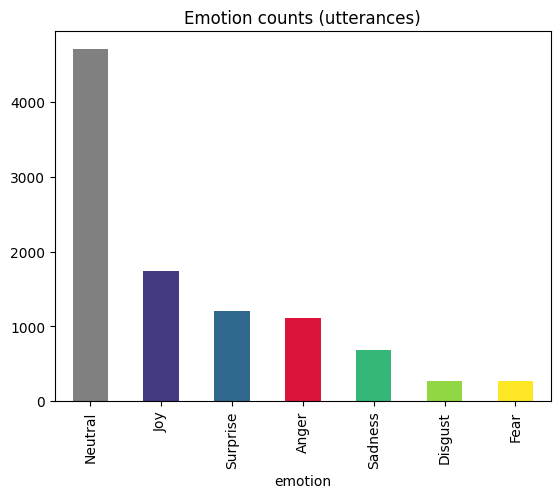

In [8]:
emotion_counts = df["emotion"].value_counts().sort_values(ascending=False)
print(emotion_counts)

emotion_counts.index = emotion_counts.index.str.capitalize()
colors = [emotion_colors[e.lower()] for e in emotion_counts.index]
emotion_counts.plot(kind="bar", title="Emotion counts (utterances)", color=colors)
plt.show()

## Total Duration per Emotion


emotion
neutral     236.098600
joy          95.275383
anger        61.328700
surprise     54.488150
sadness      43.304033
disgust      17.106033
fear         14.922533
Name: duration_s, dtype: float64


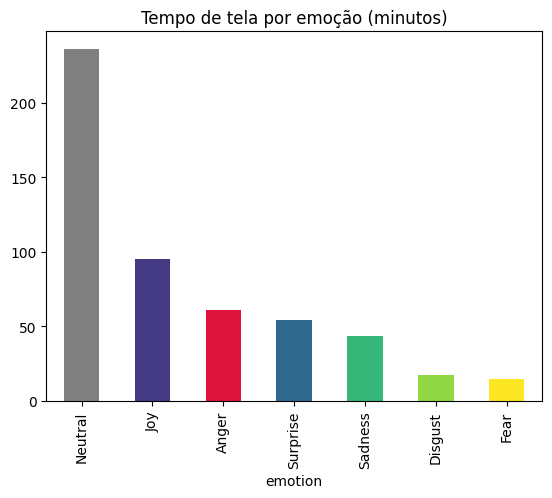

In [9]:
emotion_durations = df.groupby("emotion")["duration_s"].sum().sort_values(ascending=False)
emotion_durations = emotion_durations / 60
print(emotion_durations)

emotion_durations.index = emotion_durations.index.str.capitalize()
colors = [emotion_colors[e.lower()] for e in emotion_durations.index]
emotion_durations.plot(kind="bar", title="Tempo de tela por emoção (minutos)", color=colors)
plt.show()

## 15 Personagens Mais Relevantes


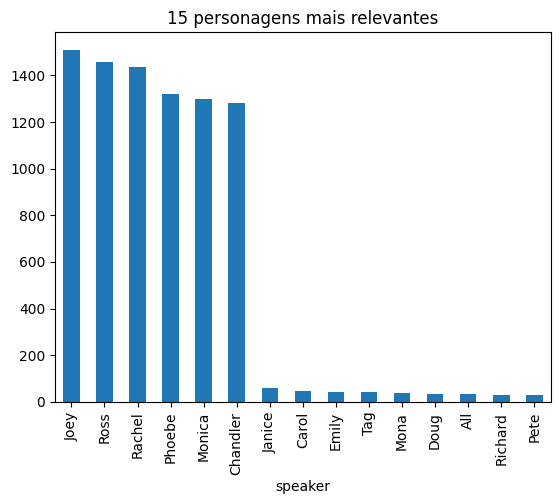

In [10]:
speaker_stats = (
    df.groupby("speaker")
    .agg(clips=("utterance", "count"), total_playtime_s=("duration_s", "sum"))
    .sort_values("clips", ascending=False)
)
speaker_stats["total_playtime_min"] = speaker_stats["total_playtime_s"] / 60

speaker_stats.head(15).plot(kind="bar", y="clips", title="15 personagens mais relevantes", legend=False)
plt.show()

## Emotion Distribution per Main Speaker (Percentage)


In [11]:
speaker_emotion_counts = df.pivot_table(
    index="speaker", columns="emotion", values="utterance", aggfunc="count", fill_value=0
)
speaker_emotion_counts.head()

emotion,anger,disgust,fear,joy,neutral,sadness,surprise
speaker,,,,,,,
1st Customer,0,0,0,1,0,0,0
2nd Customer,0,0,0,1,0,0,0
3rd Customer,0,0,0,0,1,1,0
A Female Student,0,0,0,0,1,0,0
A Student,0,0,0,0,0,0,1


## Average Utterance Duration per Emotion


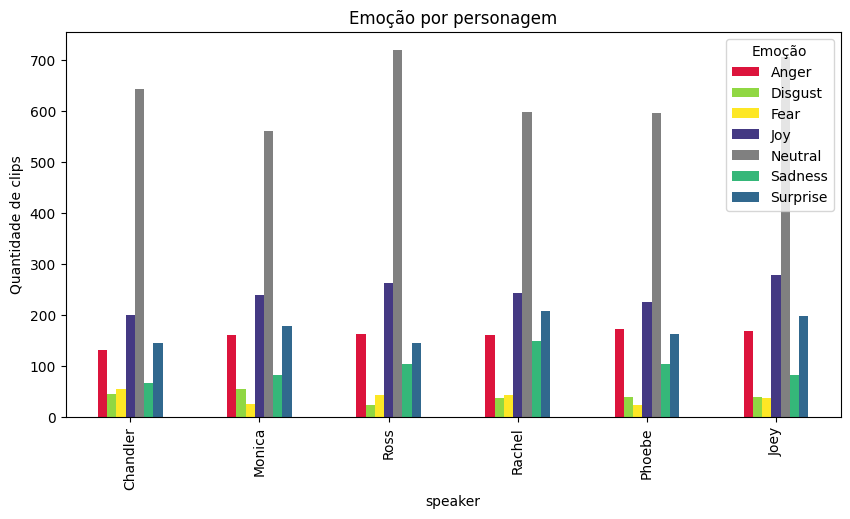

In [12]:
speaker_emotion_pct = (
    speaker_emotion_counts.div(speaker_emotion_counts.sum(axis=1), axis=0) * 100
)

ax = speaker_emotion_counts.loc[["Chandler", "Monica", "Ross", "Rachel", "Phoebe", "Joey"]].plot(
    kind="bar", 
    figsize=(10,5),
    color=[emotion_colors[col] for col in speaker_emotion_counts.columns]
)
plt.title("Emoção por personagem")
plt.ylabel("Quantidade de clips")
plt.legend(title="Emoção", labels=[col.capitalize() for col in speaker_emotion_counts.columns])
plt.show()

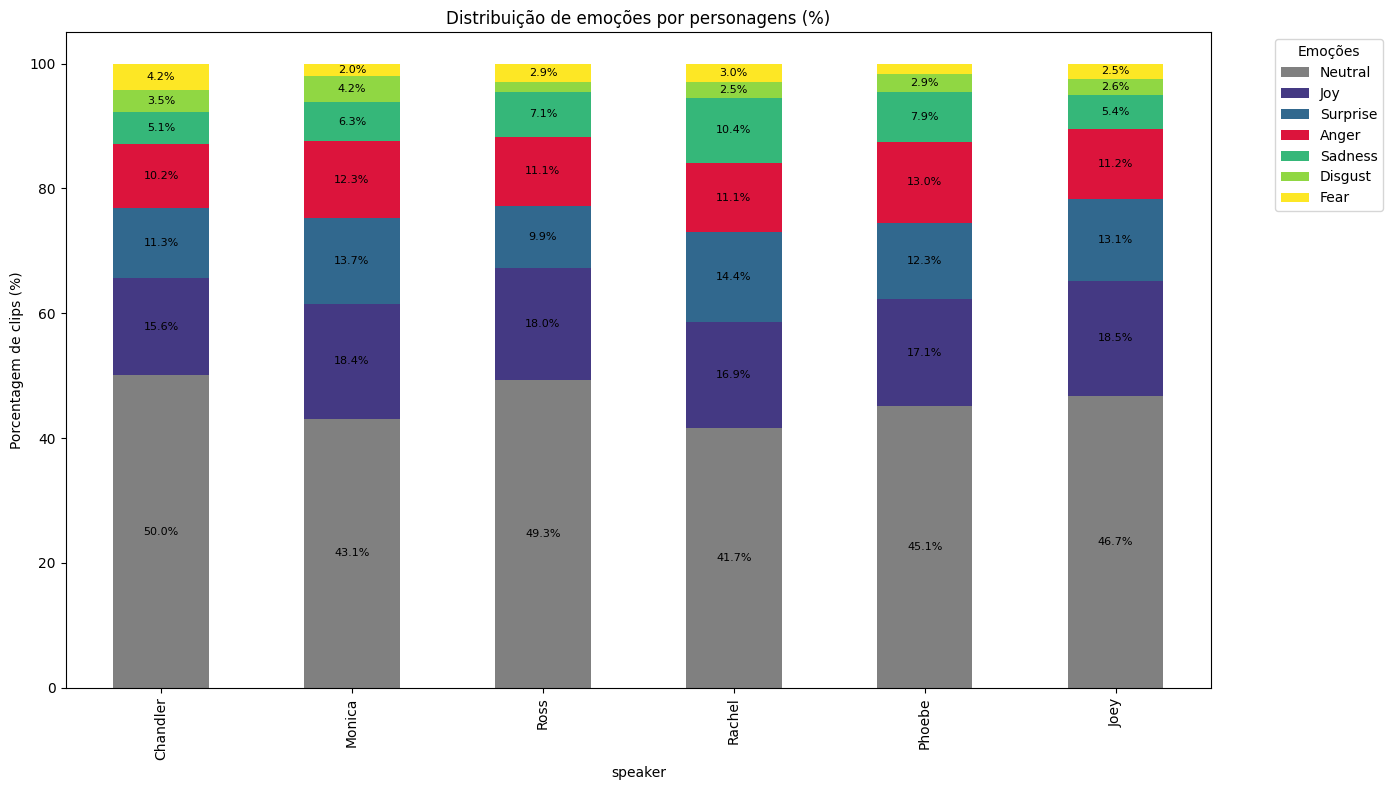

In [13]:
speaker_emotion_pct = speaker_emotion_pct[emotions]

fig, ax = plt.subplots(figsize=(14, 8))
bars = speaker_emotion_pct.loc[main_speakers].plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=[emotion_colors[e] for e in emotions]
)

ax.set_ylabel("Porcentagem de clips (%)")
ax.set_title("Distribuição de emoções por personagens (%)")
ax.legend(title="Emoções", labels=[e.capitalize() for e in emotions], bbox_to_anchor=(1.05, 1), loc="upper left")

for s_idx, speaker in enumerate(main_speakers):
    bottom = 0
    for emotion in emotions:
        val = speaker_emotion_pct.loc[speaker, emotion]
        if val > 2:
            ax.text(
                s_idx,
                bottom + val / 2,
                f"{val:.1f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )
        bottom += val

plt.tight_layout()
plt.show()

/tmp/ipykernel_278608/579979545.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


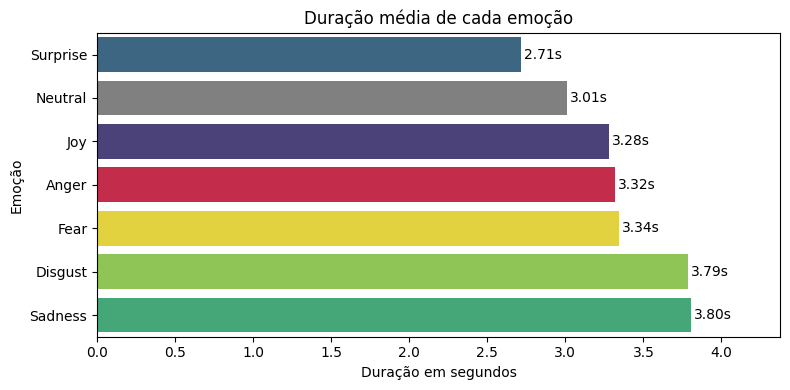

In [14]:
avg_per_emotion = df.groupby("emotion")["duration_s"].mean().sort_values()

plt.figure(figsize=(8, 4))
sns.barplot(
    x=avg_per_emotion.values,
    y=avg_per_emotion.index.str.capitalize(),
    palette=[emotion_colors[e.lower()] for e in avg_per_emotion.index]
)
plt.title("Duração média de cada emoção")
plt.xlabel("Duração em segundos")
plt.ylabel("Emoção")

for index, value in enumerate(avg_per_emotion.values):
    plt.text(value + 0.02, index, f"{value:.2f}s", va="center")

max_value = avg_per_emotion.values.max()
plt.xlim(right=max_value * 1.15)
plt.tight_layout()
plt.show()